In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Configura√ß√£o do estilo dos gr√°ficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [2]:
# Criar um DataFrame de exemplo
dados_exemplo = {
    'Turma': np.random.choice(['Turma A', 'Turma B', 'Turma C'], size=150),
    'Nota_Matematica': np.clip(np.random.normal(loc=6.5, scale=2.5, size=150), 0, 10).round(1),
    'Acesso_Internet': np.random.choice(['Sim', 'N√£o'], size=150, p=[0.8, 0.2]),
    'Genero': np.random.choice(['Masculino', 'Feminino'], size=150)
}
df_exemplo = pd.DataFrame(dados_exemplo)

# Salvar em um arquivo Excel
arquivo_excel = "notas_alunos.xlsx"
df_exemplo.to_excel(arquivo_excel, index=False)

print(f"Arquivo '{arquivo_excel}' criado com sucesso com {len(df_exemplo)} registros.")

Arquivo 'notas_alunos.xlsx' criado com sucesso com 150 registros.


In [3]:
# 1. LEITURA DE DADOS
def carregar_dados(arquivo):
    """Carrega os dados do arquivo Excel"""
    df = pd.read_excel(arquivo)
    return df

# 2. C√ÅLCULOS ESTAT√çSTICOS
def calcular_estatisticas(df):
    """Calcula estat√≠sticas descritivas para cada turma"""
    estatisticas = {}
    for turma in sorted(df['Turma'].unique()):
        dados_turma = df[df['Turma'] == turma]['Nota_Matematica']
        estatisticas[turma] = {
            'M√©dia': dados_turma.mean(),
            'Mediana': dados_turma.median(),
            'Desvio Padr√£o': dados_turma.std(),
            'Vari√¢ncia': dados_turma.var(),
            'Amplitude': dados_turma.max() - dados_turma.min(),
            'M√≠nimo': dados_turma.min(),
            'M√°ximo': dados_turma.max(),
            'Q1': dados_turma.quantile(0.25),
            'Q3': dados_turma.quantile(0.75),
            'Coef. Varia√ß√£o (%)': (dados_turma.std() / dados_turma.mean()) * 100,
            'N√∫mero de Alunos': len(dados_turma)
        }
    return pd.DataFrame(estatisticas).T

# 3. DISTRIBUI√á√ÉO DE FREQU√äNCIA E CLASSIFICA√á√ÉO
def criar_distribuicao_frequencia(df, bins=10):
    """Cria tabela de distribui√ß√£o de frequ√™ncia e classifica o desempenho"""
    distribuicoes = {}
    classificacoes = {}
    for turma in sorted(df['Turma'].unique()):
        dados_turma = df[df['Turma'] == turma]['Nota_Matematica']
        min_val, max_val = 0, 10
        intervalos = np.linspace(min_val, max_val, bins + 1)
        freq_abs = pd.cut(dados_turma, bins=intervalos, include_lowest=True, right=True).value_counts().sort_index()
        freq_rel = (freq_abs / len(dados_turma)) * 100
        dist_freq = pd.DataFrame({
            'Intervalo': [f"{intervalo.left:.1f} a {intervalo.right:.1f}" for intervalo in freq_abs.index],
            'Frequ√™ncia Absoluta': freq_abs.values,
            'Frequ√™ncia Relativa (%)': freq_rel.values.round(2)
        })
        distribuicoes[turma] = dist_freq
              
        classificacao = classificar_desempenho(dist_freq)
              
        classificacoes[turma] = classificacao
        
    return distribuicoes, classificacoes

def classificar_desempenho(dist_freq):
    """Classifica o desempenho da turma com base na tabela de distribui√ß√£o de frequ√™ncia."""
    porcentagem_0_4 = dist_freq.loc[dist_freq['Intervalo'].str.contains('^0.0 a|^1.0 a|^2.0 a|^3.0 a'), 'Frequ√™ncia Relativa (%)'].sum()
    porcentagem_6_10 = dist_freq.loc[dist_freq['Intervalo'].str.contains('^6.0 a|^7.0 a|^8.0 a|^9.0 a'), 'Frequ√™ncia Relativa (%)'].sum()
    porcentagem_8_10 = dist_freq.loc[dist_freq['Intervalo'].str.contains('^8.0 a|^9.0 a'), 'Frequ√™ncia Relativa (%)'].sum()
    porcentagem_0_6 = dist_freq.loc[dist_freq['Intervalo'].str.contains('^0.0 a|^1.0 a|^2.0 a|^3.0 a|^4.0 a|^5.0 a'), 'Frequ√™ncia Relativa (%)'].sum()
    
    resultado = {
        'Porcentagem_6_10': porcentagem_6_10,
        'Porcentagem_0_4': porcentagem_0_4,
        'Porcentagem_8_10': porcentagem_8_10
    }
    
    if porcentagem_6_10 >= 70:
        resultado.update({'Categoria': 'Homog√™neo e Suficiente', 'Descri√ß√£o': f'Mais de 70% dos alunos na faixa de 6,0 a 10,0 ({porcentagem_6_10:.1f}%)'})
    elif porcentagem_0_6 >= 70:
        resultado.update({'Categoria': 'Homog√™neo e Insuficiente', 'Descri√ß√£o': f'Mais de 70% dos alunos na faixa de 0,0 a 6,0 ({porcentagem_0_6:.1f}%)'})
    elif porcentagem_0_4 >= 30 and porcentagem_8_10 >= 30:
        resultado.update({'Categoria': 'Polarizado', 'Descri√ß√£o': f'Concentra√ß√µes nas faixas de 0-4 ({porcentagem_0_4:.1f}%) e 8-10 ({porcentagem_8_10:.1f}%)'})
    else:
        resultado.update({'Categoria': 'Heterog√™neo', 'Descri√ß√£o': 'Distribui√ß√£o dispersa sem padr√£o claro de concentra√ß√£o'})
        
    return resultado

# 4. VISUALIZA√á√ïES (MODIFICADAS PARA EXIBI√á√ÉO NO NOTEBOOK)
def visualizar_histogramas(df, bins=10):
    turmas = sorted(df['Turma'].unique())
    num_turmas = len(turmas)
    fig, axes = plt.subplots(num_turmas, 1, figsize=(10, 5 * num_turmas), squeeze=False)
    fig.suptitle('Distribui√ß√£o das Notas de Matem√°tica por Turma', fontsize=16, fontweight='bold')
    colors = sns.color_palette("Set2", num_turmas)
    
    for i, turma in enumerate(turmas):
        dados_turma = df[df['Turma'] == turma]['Nota_Matematica']
        sns.histplot(dados_turma, bins=bins, ax=axes[i, 0], color=colors[i], kde=True)
        axes[i, 0].axvline(dados_turma.mean(), color='red', linestyle='--', linewidth=2, label=f'M√©dia: {dados_turma.mean():.2f}')
        axes[i, 0].axvline(dados_turma.median(), color='green', linestyle=':', linewidth=2, label=f'Mediana: {dados_turma.median():.2f}')
        axes[i, 0].set_title(f'Turma {turma}', fontsize=12, fontweight='bold')
        axes[i, 0].set_xlabel('Nota de Matem√°tica')
        axes[i, 0].set_ylabel('Frequ√™ncia')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def visualizar_boxplot_comparativo(df):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x='Turma', y='Nota_Matematica', palette='Set2')
    plt.title('Compara√ß√£o das Notas de Matem√°tica entre Turmas', fontsize=14, fontweight='bold')
    plt.xlabel('Turma')
    plt.ylabel('Nota de Matem√°tica')
    plt.grid(True, alpha=0.3)
    plt.show()

def visualizar_barras_estatisticas(estatisticas_df):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Comparativo de M√©tricas Estat√≠sticas por Turma', fontsize=16, fontweight='bold')
    
    # M√©dia e Mediana
    estatisticas_df[['M√©dia', 'Mediana']].plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightgreen'], rot=0)
    axes[0, 0].set_title('M√©dia e Mediana das Notas')
    axes[0, 0].set_ylabel('Nota')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Desvio Padr√£o
    estatisticas_df['Desvio Padr√£o'].plot(kind='bar', ax=axes[0, 1], color='salmon', rot=0)
    axes[0, 1].set_title('Desvio Padr√£o (Dispers√£o)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Amplitude
    estatisticas_df['Amplitude'].plot(kind='bar', ax=axes[1, 0], color='lightseagreen', rot=0)
    axes[1, 0].set_title('Amplitude das Notas (Max - Min)')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Coeficiente de Varia√ß√£o
    estatisticas_df['Coef. Varia√ß√£o (%)'].plot(kind='bar', ax=axes[1, 1], color='mediumpurple', rot=0)
    axes[1, 1].set_title('Coeficiente de Varia√ß√£o (%)')
    axes[1, 1].set_ylabel('CV (%)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
def visualizar_grafico_classificacao(classificacoes):
    df_class = pd.DataFrame(classificacoes).T
    
    fig, ax = plt.subplots(figsize=(12, 7))
    x = np.arange(len(df_class.index))
    width = 0.25
    
    rects1 = ax.bar(x - width, df_class['Porcentagem_0_4'], width, label='Notas de 0 a 4 (%)', color='lightcoral')
    rects2 = ax.bar(x, df_class['Porcentagem_6_10'], width, label='Notas de 6 a 10 (%)', color='lightgreen')
    rects3 = ax.bar(x + width, df_class['Porcentagem_8_10'], width, label='Notas de 8 a 10 (%)', color='lightblue')
    
    ax.set_ylabel('Porcentagem de Alunos (%)')
    ax.set_title('Classifica√ß√£o de Desempenho por Turma', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{turma}\n({cat})" for turma, cat in df_class['Categoria'].items()], rotation=0)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Adicionar r√≥tulos nas barras
    ax.bar_label(rects1, padding=3, fmt='%.1f%%')
    ax.bar_label(rects2, padding=3, fmt='%.1f%%')
    ax.bar_label(rects3, padding=3, fmt='%.1f%%')
    
    fig.tight_layout()
    plt.show()

# 5. AN√ÅLISE ADICIONAL
def analise_acesso_internet(df):
    return df.groupby(['Turma', 'Acesso_Internet'])['Nota_Matematica'].agg(['mean', 'std', 'count']).round(2)

def analise_genero(df):
    df['Genero'] = df['Genero'].str.capitalize()
    return df.groupby(['Turma', 'Genero'])['Nota_Matematica'].agg(['mean', 'std', 'count']).round(2)

In [4]:
# Carregar os dados
df = carregar_dados(arquivo_excel)

# Exibir as primeiras linhas e informa√ß√µes gerais do DataFrame
display(Markdown("### 1. Visualiza√ß√£o Inicial dos Dados"))
display(df.head())
display(df.info())

### 1. Visualiza√ß√£o Inicial dos Dados

Turma  Nota_Matematica Acesso_Internet     Genero
0  Turma B              7.9             Sim  Masculino
1  Turma A              5.1             Sim  Masculino
2  Turma B              7.6             Sim  Masculino
3  Turma A              6.2             N√£o  Masculino
4  Turma C              3.6             Sim   Feminino

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Turma            150 non-null    object 
 1   Nota_Matematica  150 non-null    float64
 2   Acesso_Internet  150 non-null    object 
 3   Genero           150 non-null    object 
dtypes: float64(1), object(3)
memory usage: 4.8+ KB


None

### 2. Estat√≠sticas Descritivas por Turma

M√©dia  Mediana  Desvio Padr√£o  Vari√¢ncia  Amplitude  M√≠nimo  M√°ximo  \
Turma A   6.09      5.6           2.15       4.64        7.5     2.5    10.0   
Turma B   6.57      6.9           2.44       5.94        8.7     1.3    10.0   
Turma C   6.69      6.9           2.72       7.41       10.0     0.0    10.0   

           Q1    Q3  Coef. Varia√ß√£o (%)  N√∫mero de Alunos  
Turma A  4.35  7.45               35.38              47.0  
Turma B  4.90  8.55               37.09              51.0  
Turma C  4.95  9.10               40.68              52.0

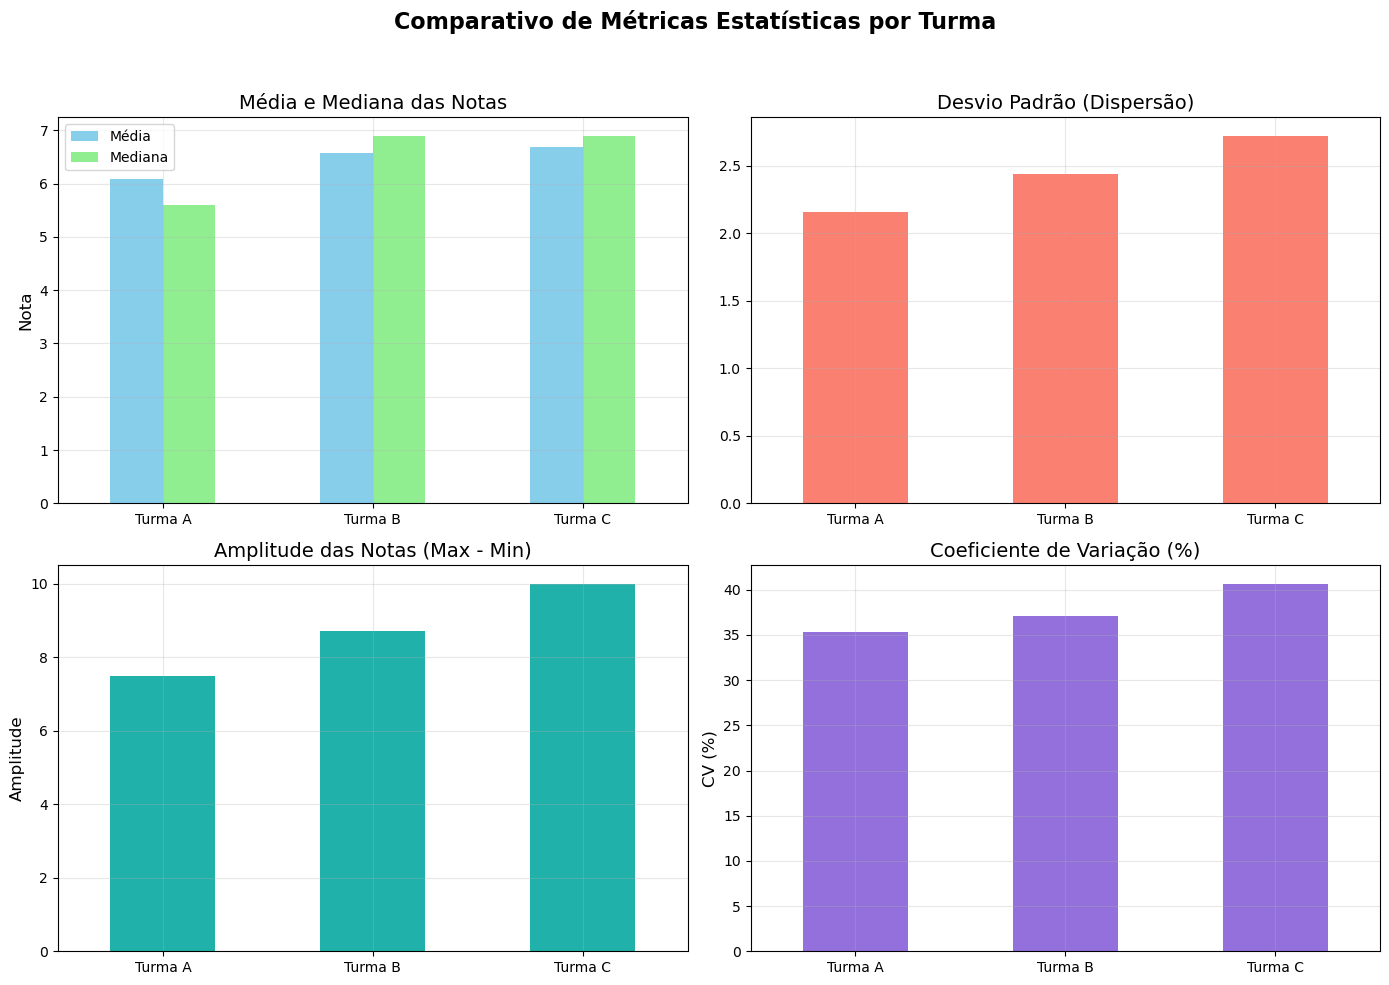

In [5]:
# Calcular e exibir as estat√≠sticas descritivas
display(Markdown("### 2. Estat√≠sticas Descritivas por Turma"))
estatisticas_df = calcular_estatisticas(df)
display(estatisticas_df.round(2))

# Visualizar o gr√°fico comparativo das estat√≠sticas
visualizar_barras_estatisticas(estatisticas_df)

### 3. Distribui√ß√£o de Frequ√™ncia e Classifica√ß√£o do Desempenho

#### Tabela de Frequ√™ncia - Turma A

Intervalo  Frequ√™ncia Absoluta  Frequ√™ncia Relativa (%)
0  -0.0 a 1.0                    0                     0.00
1   1.0 a 2.0                    0                     0.00
2   2.0 a 3.0                    1                     2.13
3   3.0 a 4.0                    7                    14.89
4   4.0 a 5.0                   12                    25.53
5   5.0 a 6.0                    7                    14.89
6   6.0 a 7.0                    6                    12.77
7   7.0 a 8.0                    4                     8.51
8   8.0 a 9.0                    3                     6.38
9  9.0 a 10.0                    7                    14.89

#### Tabela de Frequ√™ncia - Turma B

Intervalo  Frequ√™ncia Absoluta  Frequ√™ncia Relativa (%)
0  -0.0 a 1.0                    0                     0.00
1   1.0 a 2.0                    2                     3.92
2   2.0 a 3.0                    2                     3.92
3   3.0 a 4.0                    4                     7.84
4   4.0 a 5.0                    9                    17.65
5   5.0 a 6.0                    4                     7.84
6   6.0 a 7.0                    5                     9.80
7   7.0 a 8.0                   10                    19.61
8   8.0 a 9.0                    6                    11.76
9  9.0 a 10.0                    9                    17.65

#### Tabela de Frequ√™ncia - Turma C

Intervalo  Frequ√™ncia Absoluta  Frequ√™ncia Relativa (%)
0  -0.0 a 1.0                    3                     5.77
1   1.0 a 2.0                    0                     0.00
2   2.0 a 3.0                    2                     3.85
3   3.0 a 4.0                    4                     7.69
4   4.0 a 5.0                    5                     9.62
5   5.0 a 6.0                    4                     7.69
6   6.0 a 7.0                    9                    17.31
7   7.0 a 8.0                    7                    13.46
8   8.0 a 9.0                    5                     9.62
9  9.0 a 10.0                   13                    25.00

#### Tabela Resumo da Classifica√ß√£o

Categoria                                          Descri√ß√£o
Turma A  Heterog√™neo  Distribui√ß√£o dispersa sem padr√£o claro de conc...
Turma B  Heterog√™neo  Distribui√ß√£o dispersa sem padr√£o claro de conc...
Turma C  Heterog√™neo  Distribui√ß√£o dispersa sem padr√£o claro de conc...

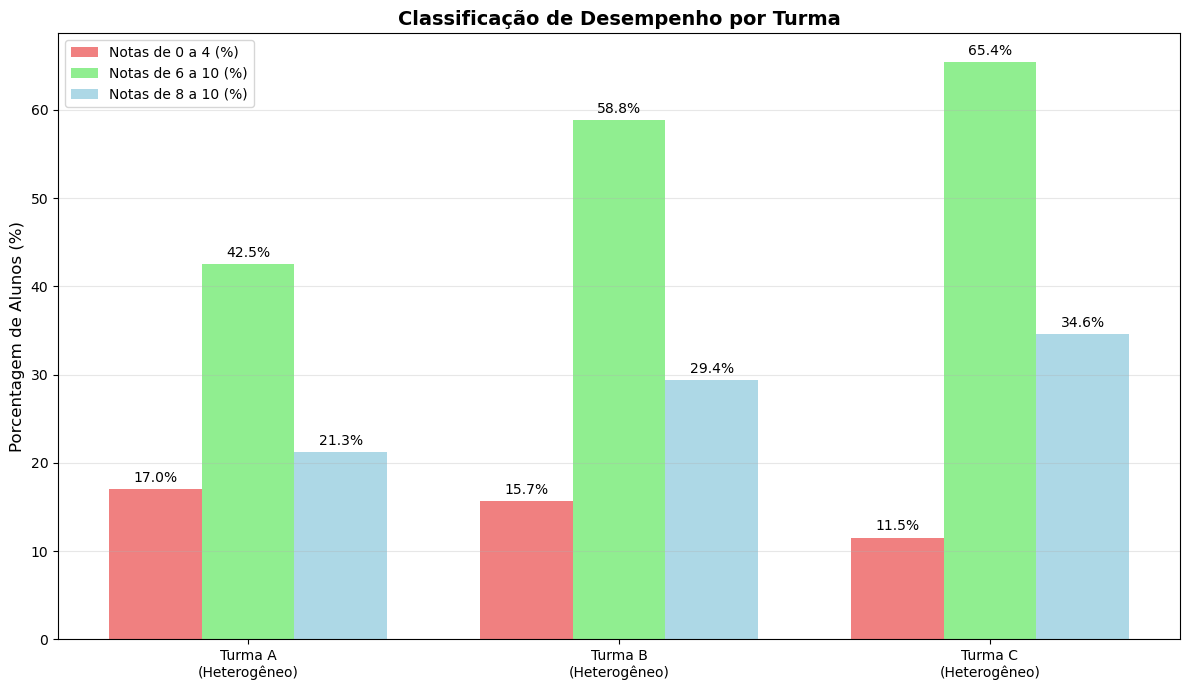

In [6]:
# Criar e exibir as tabelas de distribui√ß√£o de frequ√™ncia
display(Markdown("### 3. Distribui√ß√£o de Frequ√™ncia e Classifica√ß√£o do Desempenho"))
distribuicoes, classificacoes = criar_distribuicao_frequencia(df)

for turma, tabela in distribuicoes.items():
    display(Markdown(f"#### Tabela de Frequ√™ncia - {turma}"))
    display(tabela)

# Exibir a classifica√ß√£o consolidada
display(Markdown("#### Tabela Resumo da Classifica√ß√£o"))
df_classificacoes = pd.DataFrame(classificacoes).T
display(df_classificacoes[['Categoria', 'Descri√ß√£o']])

# Visualizar o gr√°fico de classifica√ß√£o
visualizar_grafico_classificacao(classificacoes)

### 4. Visualiza√ß√µes da Distribui√ß√£o das Notas

C:\Users\vitor\AppData\Local\Temp\ipykernel_16948\2088505551.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Turma', y='Nota_Matematica', palette='Set2')


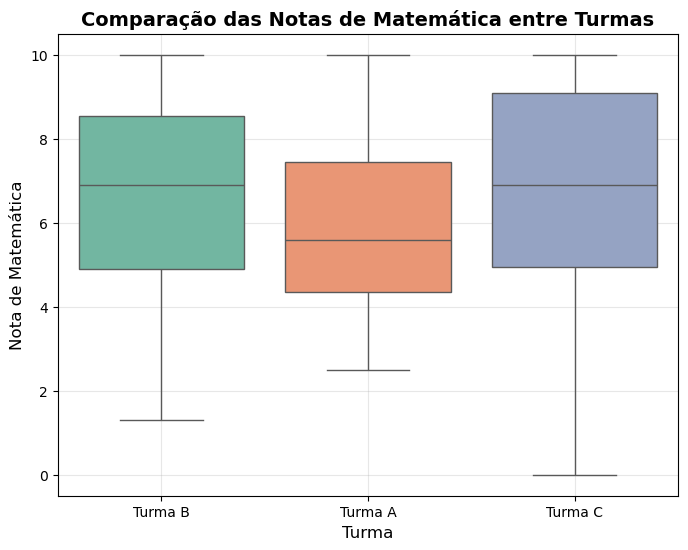

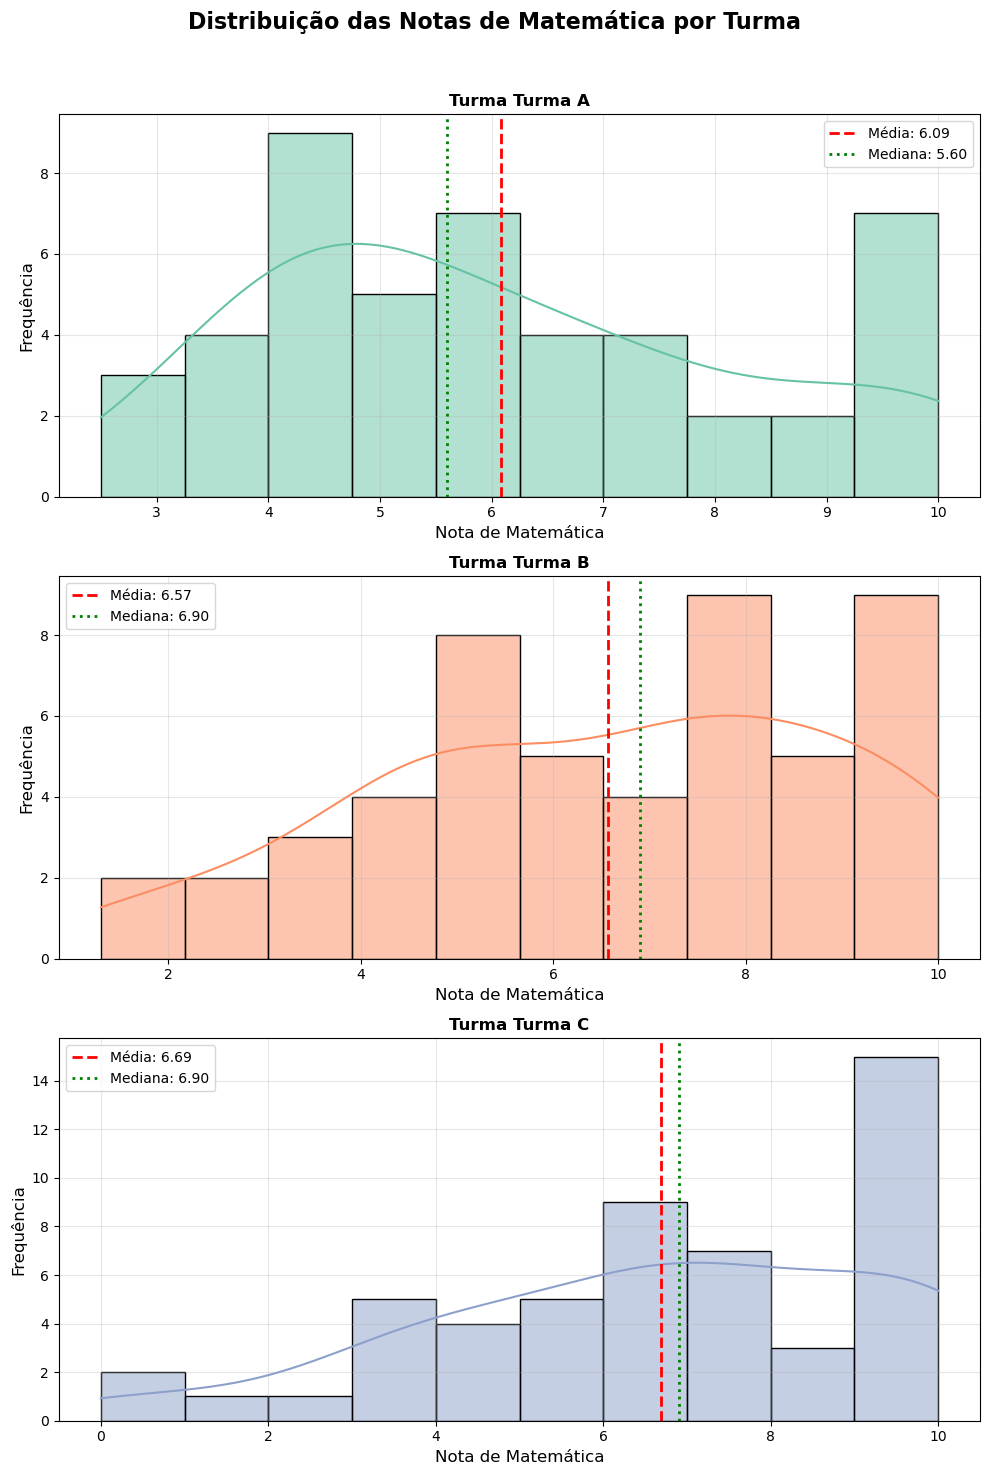

In [7]:
display(Markdown("### 4. Visualiza√ß√µes da Distribui√ß√£o das Notas"))

# Visualizar boxplot comparativo
visualizar_boxplot_comparativo(df)

# Visualizar histogramas de cada turma
visualizar_histogramas(df)

In [8]:
display(Markdown("### 5. An√°lises Adicionais"))

# An√°lise por acesso √† internet
display(Markdown("#### Desempenho por Acesso √† Internet"))
stats_internet = analise_acesso_internet(df)
display(stats_internet)

# An√°lise por g√™nero
display(Markdown("#### Desempenho por G√™nero"))
stats_genero = analise_genero(df)
display(stats_genero)

### 5. An√°lises Adicionais

#### Desempenho por Acesso √† Internet

mean   std  count
Turma   Acesso_Internet                   
Turma A N√£o              6.47  2.53      9
        Sim              6.00  2.08     38
Turma B N√£o              6.29  2.84      9
        Sim              6.63  2.38     42
Turma C N√£o              6.78  2.24     13
        Sim              6.66  2.89     39

#### Desempenho por G√™nero

mean   std  count
Turma   Genero                      
Turma A Feminino   6.07  2.06     22
        Masculino  6.10  2.28     25
Turma B Feminino   5.86  2.32     20
        Masculino  7.03  2.44     31
Turma C Feminino   6.78  3.02     26
        Masculino  6.60  2.45     26

In [9]:
display(Markdown("### 6. Insights e Recomenda√ß√µes"))

for turma, classificacao in classificacoes.items():
    categoria = classificacao['Categoria']
    display(Markdown(f"**üéØ TURMA {turma} - {categoria}**"))
    
    if categoria == 'Homog√™neo e Suficiente':
        print("  ‚úÖ Excelente desempenho coletivo. A maioria dos alunos demonstra dom√≠nio do conte√∫do.")
        print("  üí° Recomenda√ß√µes: Manter as estrat√©gias atuais e introduzir t√≥picos avan√ßados ou projetos para desafiar os alunos com melhor desempenho.")
    elif categoria == 'Homog√™neo e Insuficiente':
        print("  ‚ö†Ô∏è Desempenho geral abaixo do esperado, indicando dificuldades conceituais na maior parte da turma.")
        print("  üí° Recomenda√ß√µes: Revis√£o intensiva dos conceitos fundamentais, aulas de refor√ßo, atividades pr√°ticas e acompanhamento pr√≥ximo do progresso.")
    elif categoria == 'Polarizado':
        print("  üîÑ Grande disparidade de desempenho, com um grupo de alunos com √≥timo rendimento e outro com muitas dificuldades.")
        print("  üí° Recomenda√ß√µes: Implementar a diferencia√ß√£o pedag√≥gica, com atividades distintas para cada grupo. Criar grupos de tutoria entre pares e projetos em grupo que valorizem diferentes habilidades.")
    else: # Heterog√™neo
        print("  üìä Desempenho variado entre os alunos, sem uma concentra√ß√£o clara em nenhuma faixa de nota.")
        print("  üí° Recomenda√ß√µes: Monitoramento cont√≠nuo para identificar padr√µes emergentes. Flexibilizar as estrat√©gias de ensino para atender a diferentes ritmos de aprendizagem.")
    print("-" * 50)

### 6. Insights e Recomenda√ß√µes

**üéØ TURMA Turma A - Heterog√™neo**

  üìä Desempenho variado entre os alunos, sem uma concentra√ß√£o clara em nenhuma faixa de nota.
  üí° Recomenda√ß√µes: Monitoramento cont√≠nuo para identificar padr√µes emergentes. Flexibilizar as estrat√©gias de ensino para atender a diferentes ritmos de aprendizagem.
--------------------------------------------------


**üéØ TURMA Turma B - Heterog√™neo**

  üìä Desempenho variado entre os alunos, sem uma concentra√ß√£o clara em nenhuma faixa de nota.
  üí° Recomenda√ß√µes: Monitoramento cont√≠nuo para identificar padr√µes emergentes. Flexibilizar as estrat√©gias de ensino para atender a diferentes ritmos de aprendizagem.
--------------------------------------------------


**üéØ TURMA Turma C - Heterog√™neo**

  üìä Desempenho variado entre os alunos, sem uma concentra√ß√£o clara em nenhuma faixa de nota.
  üí° Recomenda√ß√µes: Monitoramento cont√≠nuo para identificar padr√µes emergentes. Flexibilizar as estrat√©gias de ensino para atender a diferentes ritmos de aprendizagem.
--------------------------------------------------
